# Lecture 20: Recurrent Neural Networks

In [1]:
import datetime
now = datetime.datetime.now()
print("Version: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Version: 2018-03-19 15:31:12


### This Lecture 

* The basics of RNNs 
* This is a complex and very varied subject (could do a whole course on this alone)
* Will not cover multi-layer RNNs, Very Deep RNNs, GPU optimisation, complex cells 

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")
    
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



* General class of network used to predict future outcomes 
* For examle stock prices, trajectories
* Can work on sequences of arbitrary lengths rather than fixed size 
* E.g. documents, audio, sentence construction, sentiment analysis (reviews)




* Until now looked at feedforward networks where activations flow one way 
(* except that training is done used reverse gradient descent) 
* RNNs have connections pointing backward as well 
* Simplest possible case: 

<img src="Lecture20_Images/rnn.jpeg" alt="Drawing" style="width: 500px;"/>

* At each time step (aka frame) neuron recieves input _and_ its own output
* Network is _unrolled_ over time 


* Layer of recurrent neurons, and unrolling over time 

<img src="Lecture20_Images/rnn_layer.jpeg" alt="Drawing" style="width: 900px;"/>



#### Different Types of RNN

Seq to seq (top left), seq to vector (top right), vector to seq (bottom left), delayed seq to seq (bottom right)

<img src="Lecture20_Images/seqvec.jpeg" alt="Drawing" style="width: 500px;"/>

Seq-Seq: e.g. stock prices, 
Seq-Vec: e.g. sentiment score, 
Vec-Seq: e.g. caption creation for image, 
Delayed Seq-Seq: e.g. language translation 


### Basic Example with TF

We will create an RNN composed of a layer of five recurrent neurons; using the tanh activation function. We will assume that the RNN runs over only two time steps, taking input vectors of size 3 at each time step.

Making this network, unrolled twice: 

<img src="Lecture20_Images/rnn_layer.jpeg" alt="Drawing" style="width: 500px;"/>

In [2]:
#The static_rnn() function creates an unrolled RNN network by 
#chaining cells.
n_inputs = 3 #number of input values for "lower feed in" 
n_neurons = 5 #neurons per cell
reset_graph()
 
X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

In [3]:
#BasicRNNCell, which you can think of as a little factory that creates 
#copies of the cell to build the unrolled RNN (one for each time step).
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

In [4]:
#Then we call static_rnn(), giving it the cell factory and the 
#input tensors, and telling it the data type of the inputs 
#(this is used to create the initial state matrix, which by default 
#is full of zeros). The static_rnn() function calls the cell 
#factory’s __call__() function once per input, creating two 
#copies of the cell (each containing a layer of five recurrent neurons),

output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)

Y0, Y1 = output_seqs



In [5]:
init = tf.global_variables_initializer() #initialise

In [6]:
#4 instances of 3x1 input at time-step 1
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
#4 instances of 3x1 input at time-step 2
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) 

#Y0_val and Y1_val contain the outputs of the network at both time steps for all neurons and all 
#instances in the mini-batch:
#note, no training just raw weights applied
with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [7]:
#--- for tensorboard ---
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph()) #node that write the default graph
#-----------------------
# > tensorboard --logdir tf_logs/

In [9]:
Y1_val

array([[ 0.99998885, -0.9997605 , -0.06679298, -0.9999804 ,  0.99982214],
       [-0.6524944 , -0.51520866, -0.37968954, -0.59225935, -0.08968385],
       [ 0.998624  , -0.997152  , -0.03308626, -0.9991565 ,  0.9932902 ],
       [ 0.99681675, -0.9598194 ,  0.39660636, -0.8307605 ,  0.7967197 ]],
      dtype=float32)

However this is an ugly way to make a RNN - like writing a programme without using for loops. 

Fortunately, there is a better solution: the *dynamic_rnn()* function.

The dynamic_rnn() function uses a while_loop() operation to run over the cell the appropriate number of times, and you can set swap_memory = True if you want it to swap the GPU’s memory to the CPU’s memory during backpropagation to avoid out-of-memory errors

In [11]:
n_steps = 2 #number of time steps 
n_inputs = 3 #tensor length of input
n_neurons = 5 #number in hidden layer 

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32) #auto makes the RNN

In [14]:
init = tf.global_variables_initializer()

X_batch = np.array([
        #t=0        #t=1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
    
print(outputs_val)

[[[-0.0948875  -0.7863541  -0.75976855  0.81456447 -0.8659667 ]
  [-0.9999981  -0.99989897 -0.9999942   0.9995981  -0.4085584 ]]

 [[-0.9882368  -0.9937984  -0.99848306  0.99407357 -0.9553898 ]
  [ 0.21658944 -0.20340651  0.02591269  0.44528607 -0.40116802]]

 [[-0.99991536 -0.99983823 -0.99999166  0.9998272  -0.98561245]
  [-0.9998106  -0.9926861  -0.99952865  0.9938598  -0.2555965 ]]

 [[-0.9988372   0.84198505 -0.97267133 -0.869843    0.99912703]
  [-0.97511095 -0.34840977 -0.9212813   0.39821982  0.27953893]]]


### Setting the sequence lengths

May want to have sequences of various (roll out) length

In [16]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length) #note defined sequence_length as input here

In [20]:
init = tf.global_variables_initializer()

X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors) *doesn't matter
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2]) 

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch}) 
print(outputs_val)

[[[ 0.7315571   0.34835717  0.50582    -0.22882833 -0.44022718]
  [-0.61832315  0.99999994  0.86584806  0.9793377   0.9902246 ]]

 [[ 0.8438704   0.9969755   0.8478946   0.4303219   0.09275495]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.9115922   0.9999905   0.95954454  0.81892216  0.5774025 ]
  [-0.77545464  0.99987745  0.9784728   0.7317201   0.888776  ]]

 [[-0.9995227   0.9997784   0.59744656  0.99309695  0.9984741 ]
  [-0.6212      0.5400085   0.96938425  0.19893228  0.1944804 ]]]


### Training a Squential Classifier  

Similar to normal NN except back propagation is done through time i.e. layer sequential gradients to weights assigned to match output of layers.  

<img src="Lecture20_Images/backprop.jpeg" alt="Drawing" style="width: 500px;"/>

<img src="Lecture20_Images/seqclass.jpeg" alt="Drawing" style="width: 900px;"/>

In [21]:
#setting up for the MNIST data, which has input size 28x28 pixels 
reset_graph()

n_steps = 28 
n_inputs = 28 #dimension of the input variable 
#so each input vector is 28 pixels long (a strip)

n_neurons = 150 #number of hidden neurons 
n_outputs = 10 #number of outputs 

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs]) #data  
y = tf.placeholder(tf.int32, [None]) #classes 

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [23]:
#make a fully connected layer on top 
logits = tf.layers.dense(states, n_outputs) #note that the states are passed not the outputs

#compare output to input classes
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits) 

#create the loss function to minimise 
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

#minimise the loss function 
training_op = optimizer.minimize(loss)

#print out accuracy 
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [24]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [17]:
init = tf.global_variables_initializer() #initialise

n_epochs = 100
batch_size = 150
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.94666666 Test accuracy: 0.9366
1 Train accuracy: 0.96666664 Test accuracy: 0.9488
2 Train accuracy: 0.96 Test accuracy: 0.9614
3 Train accuracy: 0.96666664 Test accuracy: 0.9572
4 Train accuracy: 0.94666666 Test accuracy: 0.9624
5 Train accuracy: 0.96 Test accuracy: 0.9634
6 Train accuracy: 0.97333336 Test accuracy: 0.9714
7 Train accuracy: 0.98 Test accuracy: 0.9686
8 Train accuracy: 0.9533333 Test accuracy: 0.9647
9 Train accuracy: 0.97333336 Test accuracy: 0.9706
10 Train accuracy: 0.97333336 Test accuracy: 0.9697
11 Train accuracy: 0.96666664 Test accuracy: 0.9692
12 Train accuracy: 0.9866667 Test accuracy: 0.9751
13 Train accuracy: 0.99333334 Test accuracy: 0.9738
14 Train accuracy: 0.9866667 Test accuracy: 0.9721
15 Train accuracy: 0.98 Test accuracy: 0.9752
16 Train accuracy: 0.99333334 Test accuracy: 0.9779
17 Train accuracy: 0.98 Test accuracy: 0.976
18 Train accuracy: 0.9866667 Test accuracy: 0.976
19 Train accuracy: 0.98 Test accuracy: 0.9709
20 Train acc

## Time Series 

* Time series e.g. such as stock prices, air temperature, brain wave patterns, and so on. 
* In this section we will train an RNN to predict the next value in a generated time series. 
* Each training instance is a randomly selected sequence of 20 consecutive values from the time series, and the target sequence is the same as the input sequence, except it is shifted by one time step into the future

<img src="Lecture20_Images/time.jpeg" alt="Drawing" style="width: 900px;"/>

In [25]:
#define the function 
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5) #some random function - try playing around

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

n_steps = 20
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution)) #all time sequence
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1) #define a region

In [27]:
reset_graph()

n_steps = 20 #20 time steps used in training
n_inputs = 1 #scalar input at each time 

n_neurons = 100 #number of hidden neurons per step
n_outputs = 1 #scalar outputs 

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs]) #instances (times)
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs]) #values 

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

* At each time step we now have an output vector of size 100. 
* But what we actually want is a single output value at each time step. 
* The simplest solution is to wrap the cell in an * OutputProjectionWrapper*. 
* A cell wrapper acts like a normal cell, proxying every method call to an underlying cell, but it also adds some functionality. The OutputProjectionWrapper adds a fully connected layer of linear neurons (i.e., without any activation function) on top of each output (but it does not affect the cell state).

<img src="Lecture20_Images/projwrap.jpeg" alt="Drawing" style="width: 900px;"/>

In [28]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs) #define the projection wrapped cell

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32) #unroll 

In [29]:
learning_rate = 0.001

# define loss function as the MSE: output-training y
loss = tf.reduce_mean(tf.square(outputs - y)) 

#training 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [22]:
n_iterations = 1500
batch_size = 50
saver = tf.train.Saver() #save for later 
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") # not shown in the book

0 	MSE: 11.259661
100 	MSE: 0.4836635
200 	MSE: 0.16478088
300 	MSE: 0.09116672
400 	MSE: 0.07200017
500 	MSE: 0.06348497
600 	MSE: 0.0566475
700 	MSE: 0.050834212
800 	MSE: 0.05238466
900 	MSE: 0.04912186
1000 	MSE: 0.04825784
1100 	MSE: 0.050785255
1200 	MSE: 0.042920403
1300 	MSE: 0.049169898
1400 	MSE: 0.04344405


INFO:tensorflow:Restoring parameters from ./my_time_series_model


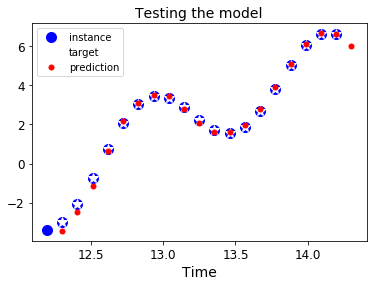

In [23]:
with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "./my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

* Now that we have a model that can predict the future, we can use it to generate some creative sequences.
* All we need is to provide it a seed sequence containing n_steps values (e.g., full of zeros), use the model to predict the next value, append this predicted value to the sequence. 
* e.g. feed all words from a novel and write a new chapter etc.


In [24]:
#creative sequences made by giving different inputs extended beyond the training range
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


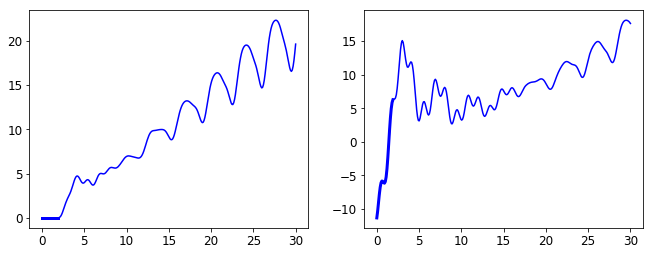

In [25]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.show()

### Very simple multi-cell example 

* Can also have multiple cells per time step - defining a deep RNNS 
* Built by stacking cells into a MultiRNNCell().
* Subject gets very complex very fast - will keep it simple 


<img src="Lecture20_Images/deeprnn.jpeg" alt="Drawing" style="width: 500px;"/>


In [34]:
reset_graph()

n_inputs = 2 #vector input 
n_steps = 5 #5 step unroll 

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

n_neurons = 100 #100 neurons per roll 
n_layers = 3 #number of vertical layers 

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons) for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)

cell = multi_layer_cell
#n_outputs=1
#cell = tf.contrib.rnn.OutputProjectionWrapper(multi_layer_cell,output_size=n_outputs) #define the projection wrapped cell

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [35]:
init = tf.global_variables_initializer()

X_batch = np.random.rand(2, n_steps, n_inputs) #just input some random numbers as an example

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})
    
outputs_val.shape

(2, 5, 100)

End

## Example 

<img src="Lecture20_Images/frenchenglish.jpeg" alt="Drawing" style="width: 900px;"/>

Note that: 
* English sentences are reversed before they are fed to the encoder. For example “I drink milk” is reversed to “milk drink I.” This ensures that the beginning of the English sentence will be fed last to the encoder, which is useful because that’s generally the first thing that the decoder needs to translate.
* Each word is initially represented by a simple integer identifier (e.g., 288 for the word “milk”).
* At each step, the decoder outputs a score for each word in the output vocabulary (i.e., French), and then the Softmax layer turns these scores into probabilities.

* At inference time (after training), you will not have the target sentence to feed to the decoder. Instead, simply feed the decoder the word that it output at the previous step (this requirew an embedding lookup that is not shown on the diagram).

<img src="Lecture20_Images/inference.jpeg" alt="Drawing" style="width: 900px;"/>




### No Exercise! 

* Instead go through these slides and understand the functionality 
* Also read and look at examples here https://www.tensorflow.org/tutorials/recurrent